In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.decomposition import PCA
from feature_engine.outliers import Winsorizer
from sklearn.metrics import mean_absolute_error, mean_squared_error


In [2]:
df_missing = pd.read_csv('../Data/df_transformed.csv')
df_missing.drop('Unnamed: 0',axis=1,inplace=True)
df_imputed = pd.read_csv('../Data/dfi_transformed.csv')
df_imputed.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
Models = {
}

In [4]:
def model(number,return_model=False, return_xy=False):
    global Models,df_missing,df_imputed
    info = {}
    info['number']=number
    imputed = False
    num_variables=['RIDAGEYR','BPXPLS','Systolic','Diastolic']
    cat_variables =['RIAGENDR','RIDRETH3']
    info['imputed']=1
    if number % 2 == 0: # use imputed values (remember to drop na before train test split)
        df = df_missing
        info['imputed']=0
    else:
        df = df_imputed
        imputed = True
        cat_variables.extend(['BPXPLS_i','Systolic_i','Diastolic_i'])
    number = (number - number%2)//2
    info['drop outliers']=0    
    if number%2==1: # drop outliers
        info['drop outliers']=1
        df = df[df.outlier==0].copy()
    number = (number - number%2)//2
    info['limit y range']=0    
    if number % 2 == 1: # reduce y range
        info['limit y range']=1
        number -= 1
        df = df[(df.LBXTC>=100)&(df.LBXTC<400)].copy()
    number = number//2
    info['bmi only']=1    
    if number % 2 == 1: # use height and weight
        info['bmi only']=0
        number = number - 1
        num_variables.extend([ 'BMXWT', 'BMXHT'])
        if imputed:
            cat_variables.extend(['BMXWT_i', 'BMXHT_i'])
    else:
        num_variables.append('BMXBMI')
        if imputed:
            cat_variables.append('BMXBMI_i')
    number = number//2
    info['include pulse irregularity']=0    
    if number%2==1: # include irregular pulse
        info['include pulse irregularity']=1
        number -= 1
        cat_variables.append('BPXPULS')
        if imputed:
            cat_variables.append('BPXPULS_i')
    number = number//2
    info['include chronic conditions']=0
    if number % 2 == 1: # include chronic conditions
        number -= 1
        info['include chronic conditions']=1
        cat_variables.extend(['BPQ020', 'BPQ050A', 'BPQ080','BPQ100D', 'DIQ010', 'MCQ170M'])
        if imputed:
            cat_variables.extend(['BPQ020_i', 'BPQ050A_i', 'BPQ080_i', 'BPQ100D_i', 'DIQ010_i','MCQ170M_i'])
    number = number//2
    info['use transformed physical activity']=0
    if number % 2 == 1: # use transformed physical activity
        number -= 1
        info['use transformed physical activity']=1
        num_variables.append('MET_rec')
        if imputed:
            cat_variables.append('MET_rec_i')
    else:
        num_variables.extend(['PAQ655','PAD660','PAQ670','PAD675'])
        if imputed:
            cat_variables.extend(['PAQ655_i','PAD660_i','PAQ670_i','PAD675_i'])
    number = number // 2
    info['include nutrients']=0
    info['nutrient variable type']=np.nan    
    if number%2 == 0: # don't include nutrients
        number = (number - number%6)//6
    else:
        info['include nutrients']=1
        number = (number-1)//2
        if number % 3 == 0: # include original nutrients
            num_variables.extend(['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA'])
            cat_variables.append('DR1_300')
            if imputed:
                cat_variables.append('DR1_300_i')
            info['nutrient variable type']='original'
        elif number % 3 == 1: # include transformed nutrients
            info['nutrient variable type']='transformed'
            num_variables.extend(['DR1TKCAL_t',
       'DR1TPROT_t', 'DR1TCARB_t', 'DR1TSUGR_t', 'DR1TFIBE_t', 'DR1TTFAT_t',
       'DR1TSFAT_t', 'DR1TMFAT_t', 'DR1TPFAT_t', 'DR1TCHOL_t', 'DR1TSODI_t',
       'DR1TVD_t', 'DR1TCALC_t', 'DR1TIRON_t', 'DR1TPOTA_t'])
            if imputed:
                cat_variables.append('DR1_300_i')
        else: # include both
            info['nutrient variable type']='both'
            num_variables.extend(['DR1TKCAL', 'DR1TPROT', 'DR1TCARB', 'DR1TSUGR',
       'DR1TFIBE', 'DR1TTFAT', 'DR1TSFAT', 'DR1TMFAT', 'DR1TPFAT', 'DR1TCHOL',
       'DR1TSODI', 'DR1TVD', 'DR1TCALC', 'DR1TIRON', 'DR1TPOTA','DR1TKCAL_t',
       'DR1TPROT_t', 'DR1TCARB_t', 'DR1TSUGR_t', 'DR1TFIBE_t', 'DR1TTFAT_t',
       'DR1TSFAT_t', 'DR1TMFAT_t', 'DR1TPFAT_t', 'DR1TCHOL_t', 'DR1TSODI_t',
       'DR1TVD_t', 'DR1TCALC_t', 'DR1TIRON_t', 'DR1TPOTA_t'])
            if imputed:
                cat_variables.append('DR1_300_i')
        number = (number - number%3)//3
    info['include alcohol and tobacco']=0
    info['alcohol variable type']=np.nan
    
    if number % 2 == 0: # don't include alcohol and tobacco
        number = (number - number % 6)//6
    else: # include alcohol and tobacco
        number = (number - 1)//2
        # add tobacco here
        cat_variables.append('SMQ681')
        info['include alcohol and tobacco']=1
        if imputed:
            cat_variables.append('SMQ681_i')
        if number % 3 == 0: # include original alcohol quantities
            info['alcohol variable type']='original'
            num_variables.extend([ 'ALQ120Q','ALQ130'])
            cat_variables.append('ALQ120U')
            if imputed:
                cat_variables.extend(['ALQ120Q_i', 'ALQ120U_i', 'ALQ130_i'])
        elif number % 3 == 1: # include transformed alcohol quantities
            info['alcohol variable type']='transformed'
            num_variables.append('avgALC')
            if imputed:
                cat_variables.append('avgALC_i')
        else: # include both
            info['alcohol variable type']='both'
            num_variables.extend([ 'ALQ120Q','ALQ130','avgALC'])
            cat_variables.append('ALQ120U')
            if imputed:
                cat_variables.extend(['ALQ120Q_i', 'ALQ120U_i', 'ALQ130_i','avgALC_i'])
        number = (number-number%3)//3
    df = df[num_variables+cat_variables+['LBXTC','log_LBXTC']].copy()
    df.dropna(inplace=True)
    y = df.LBXTC
    info['log transform y']=0
    if number % 2 == 1: # use log transformed y
        info['log transform y']=1
        number -= 1
        y = df.log_LBXTC
    number = number//2
    X = df[num_variables+cat_variables].copy()
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=675, test_size=0.2)
    numeric_transformer = Pipeline(steps=[('scalar',StandardScaler())])
    numeric_transformer.steps.pop(0)
    info['Winsorize x']=0
    if number % 2 == 1: # Winsorize x
        info['Winsorize x']=1
        numeric_transformer.steps.insert(0,('winsorizor',Winsorizer()))
        number -= 1
    number = number//2
    info['log transform numeric variables']=0
    if number % 2 == 1: # log transform x
        info['log transform numeric variables']=1
        number -= 1
        numeric_transformer.steps.insert(0,('log transform x',FunctionTransformer(np.log1p)))
    number = number // 2
    info['scale features']=0
    if number%2==1: # add a scaler
        number -= 1
        info['scale features']=1
        numeric_transformer.steps.append(('scalar',StandardScaler()))
    number = number//2
    preprocessor_used=0
    if len(numeric_transformer.steps)==0:
        rf1 = Pipeline(steps=[('rf',RandomForestRegressor(random_state=75))])   
    else:
        preprocessor_used=1
        preprocessor = ColumnTransformer(transformers=[('num',numeric_transformer,num_variables)],remainder='passthrough')
        rf1 = Pipeline(steps =[
            ('preprocessor',preprocessor),
            ('rf', RandomForestRegressor(random_state=75))])
        
    info['include PCA']=0
    if number % 2 == 1: # add PCA
        rf1.steps.insert(preprocessor_used,("pca",PCA(0.95)))
        info['include PCA']=1

    rf1.fit(X_train,y_train)

    r2 = rf1.score(X_train,y_train)
    info['r2']=r2
    k = rf1.named_steps['rf'].n_features_in_
    n = X_train.shape[0]
    ar2 = 1-((1-r2)/(n-1))/(n-k-1)
    info['adjusted r2']=ar2
    y_train_preds = rf1.predict(X_train)
    y_preds = rf1.predict(X_test)
    
    info['training MAE'] = mean_absolute_error(y_train,y_train_preds)
    info['testing MAE'] = mean_absolute_error(y_test,y_preds)
    info['training RMSE'] = mean_squared_error(y_train,y_train_preds,squared=False)
    info['testing RMSE'] = mean_squared_error(y_test,y_preds,squared=False)
    info['MAE percent difference'] = (info['testing MAE']-info['training MAE'])/info['training MAE']
    info['RMSE percent difference'] = (info['testing RMSE']-info['training RMSE'])/info['training RMSE']
    if return_model:
        if return_xy:
            return (rf1, X_train, X_test, y_train, y_train_preds,y_test,y_preds)
        return (rf1, info)
    for key in info.keys():
        if key not in Models:
            Models[key]=[]
        Models[key].append(info[key])

In [5]:
model_numbers = []
for i in range(100):
    n = np.random.randint(2*73728)
    while n in model_numbers:
        n = np.random.randint(2*73728)
    model_numbers.append(n)
    model(n)
models = pd.DataFrame(Models)
top_10 = models.sort_values(by='adjusted r2',ascending=False).head(10)
top_10

,number,imputed,drop outliers,limit y range,bmi only,include pulse irregularity,include chronic conditions,use transformed physical activity,include nutrients,nutrient variable type,...,scale features,include PCA,r2,adjusted r2,training MAE,testing MAE,training RMSE,testing RMSE,MAE percent difference,RMSE percent difference
45,46563,1,1,0,1,0,1,1,1,transformed,...,1,0,0.884870,1.0,10.868950,29.465092,14.240007,39.704275,1.710942,1.788220
17,46523,1,1,0,0,1,1,0,1,transformed,...,1,0,0.883930,1.0,10.904551,29.726440,14.298007,39.987750,1.726058,1.796736
10,1059,1,1,0,1,0,1,0,0,NaN,...,0,0,0.882341,1.0,11.003466,29.009191,14.395531,39.075205,1.636369,1.714398
70,48745,1,0,0,0,0,1,1,0,NaN,...,1,0,0.881070,1.0,10.918016,29.922508,14.186228,41.401598,1.740654,1.918436
91,61301,1,0,1,1,1,1,1,0,NaN,...,1,0,0.881638,1.0,0.057032,0.152320,0.072848,0.193433,1.670792,1.655281
48,57073,1,0,0,1,1,1,1,1,original,...,1,0,0.880308,1.0,10.945069,29.733089,14.231574,41.379213,1.716574,1.907564
47,42485,1,0,1,1,1,1,1,1,original,...,1,0,0.881840,1.0,0.057077,0.151022,0.072786,0.193267,1.645946,1.655256
29,70205,1,0,1,0,1,1,0,0,NaN,...,1,0,0.881097,1.0,0.057224,0.153071,0.073015,0.194571,1.674921,1.664822
50,2429,1,0,1,0,1,1,1,0,NaN,...,0,0,0.879074,1.0,10.829624,29.093023,13.984426,37.500277,1.686430,1.681574
11,27941,1,0,1,1,0,1,0,0,NaN,...,0,0,0.878280,1.0,10.880149,28.983326,14.030264,37.274998,1.663872,1.656757


In [6]:
top_10.transpose(copy=True)

,45,17,10,70,91,48,47,29,50,11
number,46563,46523,1059,48745,61301,57073,42485,70205,2429,27941
imputed,1,1,1,1,1,1,1,1,1,1
drop outliers,1,1,1,0,0,0,0,0,0,0
limit y range,0,0,0,0,1,0,1,1,1,1
bmi only,1,0,1,0,1,1,1,0,0,1
include pulse irregularity,0,1,0,0,1,1,1,1,1,0
include chronic conditions,1,1,1,1,1,1,1,1,1,1
use transformed physical activity,1,0,0,1,1,1,1,0,1,0
include nutrients,1,1,0,0,0,1,1,0,0,0
nutrient variable type,transformed,transformed,NaN,NaN,NaN,original,original,NaN,NaN,NaN


In [7]:
rf1, X_train, X_test, y_train, y_train_preds,y_test,y_preds = model(46563, return_model=True, return_xy=True)

In [8]:
X_train.shape

(3705, 41)

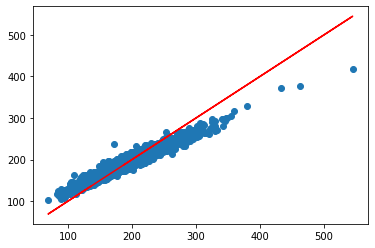

In [9]:
plt.scatter(y_train, y_train_preds)
plt.plot(y_train, y_train, color="red")

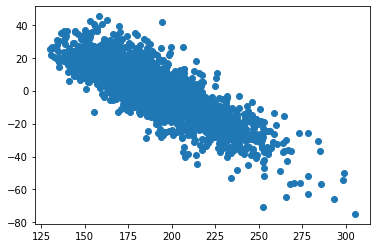

In [19]:
residuals_train = y_train_preds-y_train
plt.scatter(y_train_preds,residuals_train)

In [12]:
# need to now do grid search